## Connect to your database

In [219]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
from numpy import interp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import to_rgb
import matplotlib.colors as mcol
import matplotlib.cm as cm
import pylab as pl
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

##### This section of the code uses credentials to a database stored in an external json file to connect to the database with said credentials in order for us to be able to run any sql queries. We will use the data from the sql queries to show using a heatmap how often a color is used in pull requests. A heatmap is a data visualization technique that shows magnitude of a phenomenon, in this case the amount of times a color is used, as color in two dimensions. It may sound confusing to use colors to describe colors, but the heat map allows us to show the intensity of color usage similar to intensity of heat when using thermal vision.

## Retrieving Available Data and Making It Useful for Later

In [153]:
repolist = pd.DataFrame()

repo_query1 = salc.sql.text(f"""c
                SELECT
                    repo_id,
                    pull_request_labels.pr_src_color,
                    COUNT ( * ) AS repo_color_count
                FROM
                    pull_requests,
                    pull_request_labels
                WHERE
                    pull_requests.pull_request_id = pull_request_labels.pull_request_id --pull_requests.pr_created_at,
                GROUP BY
                    repo_id,
                    pull_request_labels.pr_src_color
                    order by repo_color_count desc;
                    """)

repo_query2 = salc.sql.text(f"""
                SELECT
                    pull_request_labels.pr_src_color,
                    COUNT ( * ) AS repo_color_count
                FROM
                    pull_requests,
                    pull_request_labels
                WHERE
                    pull_requests.pull_request_id = pull_request_labels.pull_request_id --pull_requests.pr_created_at,
                GROUP BY
                    pull_request_labels.pr_src_color
                order by repo_color_count desc;
                """)

repolist = pd.read_sql(repo_query2, con=engine)

display(repolist)

color_list, color_count = [],[]
for index, row in repolist.iterrows():
    #print(row['pr_src_color'], " ", row['repo_color_count'])
    temp = '#' + row['pr_src_color']
    temp = rgb_to_hsv(to_rgb(temp))
    color_list.append(temp)
    color_count.append(row['repo_color_count'])

,pr_src_color,repo_color_count
0,21ef3d,16
1,84b6eb,11
2,D22BF9,9
3,0366d6,8
4,e6e6e6,6
...,...,...
57,5546db,1
58,56a8ff,1
59,58bc0b,1
60,6f31ea,1


##### The table above is the result of the sql query repo_query2. Half of the query gets the list of strings called pr_src_color, which individually is 3 consecutive hexidecimal numbers that correspond to the color someone used when submitting a pull request. The list of string has no repeats because the other half of the query is how often each corresponding color was used. In the code, after showing the list of query results, we store the color strings as useful hex rgb strings and the count of their uses in lists to be used later.

## Plotting the Color Spectrum for Reference for the Heatmap

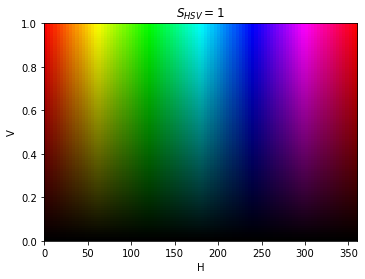

100


In [158]:
V, H = np.mgrid[0:1:100j, 0:1:100j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)
pl.imshow(RGB, origin="lower", extent=[0,360,0,1], aspect=250)
pl.xlabel("H")
pl.ylabel("V")
pl.title("$S_{HSV}=1$")
pl.show()

print(len(RGB))

##### The graph above is a plot of colors from red to green to blue and back to red based on their hue, saturation, and value. This will be used to show what colors the points on the heat map correspond to. So for example points on the heat map near the left or right side will correspond to a more red color, while points in the middle correspond to a more cyan color. Given that as the value of the color goes down the colors all tend to blend into black, most of the points for the colors that aren't black will be a lot closer to the top of the heat map since their saturation will be closer to the max.

## Plotting a Heatmap with Corresponding Color Usage

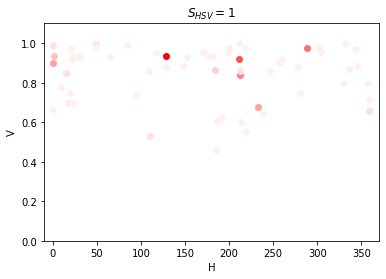

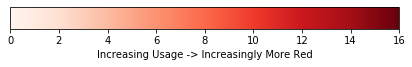

In [223]:
#Needs to be changed or updated. The color spectrum can also be changed or updated if an easier heat map gets found.
RGB = []
for x,y in zip(color_list, color_count):
    heat_color = 255 - int(interp(y, [0,16], [0,255]))
    heat_color = ("#ff" + format(heat_color, '02x') + format(heat_color, '02x'))
    pl.plot(interp(x[0], [0,1],[0,360]), x[2], 'o', color=heat_color)

pl.axis([-10,370,0,1.1])
pl.xlabel("H")
pl.ylabel("V")
pl.title("$S_{HSV}=1$")
pl.show()

fig = plt.figure(figsize=(6,2))
axes = fig.add_axes([0.05, 0.80, 0.90, 0.15])
norm = mpl.colors.Normalize(vmin=0, vmax=16)
colorbar_base = mpl.colorbar.ColorbarBase(axes, cmap=mpl.cm.Reds, norm=norm, orientation='horizontal')
colorbar_base.set_label('Increasing Usage -> Increasingly More Red')

##### The graph shown above plots the colors used in pull requests according to where they fall on the HSV spectrum graph above this code, and then uses the amount of times a color is used, to assign a heat to the corresponding color point. The x,y points correspond the the colors on the first graph, while the color of the point ranges from close to white for a pull request color being used only once, to a bright red for the pull request color being used the most. Most of the points on this heat map, that aren't completely unused color, are for a color only being used once. Upon the completion of this project there are only 62 uniquely used colors from the pull requests, and the most a color has been used was 16 times. If the data were more wide spread or varied than the color variation of the heat map might be a little higher.